In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 128 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


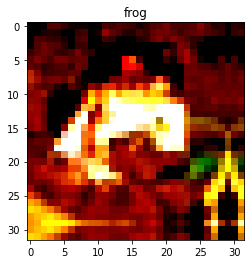

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_sgd_warmup_consine_batch.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.4
lr_min=0.001
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)



if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 2.1719525244534776, Test loss 1.5796041201941575, Train accuracy 28.829523657289002, Test accuracy 42.41495253164557, Cost 77.93078827857971 s
Epoch 2, Train loss 1.5218921082708843, Test loss 1.29710609098024, Train accuracy 44.40297315553631, Test accuracy 53.20411392405063, Cost 77.63084864616394 s
Epoch 3, Train loss 1.2592957618901186, Test loss 1.0069060084186023, Train accuracy 54.42695012787724, Test accuracy 63.528481012658226, Cost 77.9852397441864 s
Epoch 4, Train loss 0.9860970254444406, Test loss 0.8454901757119577, Train accuracy 65.28732416879795, Test accuracy 70.16416139240506, Cost 78.09000968933105 s
Epoch 5, Train loss 0.8259914662222119, Test loss 0.7156381667414798, Train accuracy 70.8284047314578, Test accuracy 75.07911392405063, Cost 79.01592421531677 s
Model saved in epoch 5
Epoch 6, Train loss 0.7225968164708608, Test loss 0.6392001679426507, Train accuracy 74.7258631713555, Test accuracy 78.48101265822785, Cost 77.8190643787384 s
Epoch 7, 

Epoch 50, Train loss 0.05034551506235605, Test loss 0.39575696302742897, Train accuracy 98.27285805626599, Test accuracy 91.08979430379746, Cost 76.2963216304779 s
Model saved in epoch 50
Epoch 51, Train loss 0.04784652720207868, Test loss 0.4167771692140193, Train accuracy 98.29443734015345, Test accuracy 90.90189873417721, Cost 72.94016408920288 s
Epoch 52, Train loss 0.04329962174996467, Test loss 0.3968802723986439, Train accuracy 98.4994405370844, Test accuracy 91.04034810126582, Cost 72.85789918899536 s
Epoch 53, Train loss 0.039505093663935655, Test loss 0.4208213745887521, Train accuracy 98.69085677749361, Test accuracy 91.24802215189874, Cost 72.94453859329224 s
Epoch 54, Train loss 0.03868658050878064, Test loss 0.44554688338237475, Train accuracy 98.63890664961637, Test accuracy 90.97112341772151, Cost 76.79960227012634 s
Epoch 55, Train loss 0.04128867556499389, Test loss 0.438130609030965, Train accuracy 98.57416879795396, Test accuracy 90.99090189873418, Cost 72.855154991

Epoch 99, Train loss 0.01342657718470569, Test loss 0.4996300690536258, Train accuracy 99.53764386189258, Test accuracy 91.9501582278481, Cost 76.68691039085388 s
Epoch 100, Train loss 0.014069630196714021, Test loss 0.5167639446032198, Train accuracy 99.53844309462916, Test accuracy 91.62381329113924, Cost 76.52370977401733 s
Model saved in epoch 100
Epoch 101, Train loss 0.014385476515757467, Test loss 0.4809710839881173, Train accuracy 99.52445652173913, Test accuracy 91.96004746835443, Cost 77.31507515907288 s
Epoch 102, Train loss 0.014718796388534775, Test loss 0.46719508401200743, Train accuracy 99.50327685421995, Test accuracy 92.0886075949367, Cost 77.13131880760193 s
Epoch 103, Train loss 0.01392195793177636, Test loss 0.5027124459230448, Train accuracy 99.54243925831202, Test accuracy 91.7820411392405, Cost 77.17294478416443 s
Epoch 104, Train loss 0.01291432541315271, Test loss 0.47085135986533344, Train accuracy 99.56441815856778, Test accuracy 91.96993670886076, Cost 77.4

Epoch 148, Train loss 0.006172601531827352, Test loss 0.5507740238799325, Train accuracy 99.79020140664962, Test accuracy 92.26661392405063, Cost 77.85418176651001 s
Epoch 149, Train loss 0.005256124616058896, Test loss 0.5387648328007022, Train accuracy 99.8289641943734, Test accuracy 92.33583860759494, Cost 73.71258234977722 s
Epoch 150, Train loss 0.00522995620793135, Test loss 0.5407722164181215, Train accuracy 99.82177109974424, Test accuracy 92.38528481012658, Cost 77.79280829429626 s
Model saved in epoch 150
Epoch 151, Train loss 0.004103407956148765, Test loss 0.5227748511618451, Train accuracy 99.8701246803069, Test accuracy 92.69185126582279, Cost 77.24376702308655 s
Epoch 152, Train loss 0.0030995837668205337, Test loss 0.5248184039057056, Train accuracy 99.91008631713555, Test accuracy 92.62262658227849, Cost 78.23932409286499 s
Epoch 153, Train loss 0.002952854131079295, Test loss 0.5304866581212117, Train accuracy 99.89609974424552, Test accuracy 92.61273734177215, Cost 7

Epoch 196, Train loss 0.00115806774395934, Test loss 0.6085959842216365, Train accuracy 99.97002877237851, Test accuracy 92.45450949367088, Cost 112.03691172599792 s
Epoch 197, Train loss 0.0016622334937234605, Test loss 0.6101623609473433, Train accuracy 99.9440537084399, Test accuracy 92.65229430379746, Cost 110.40328931808472 s
Epoch 198, Train loss 0.0015861522927577804, Test loss 0.589968818652479, Train accuracy 99.95004795396419, Test accuracy 92.52373417721519, Cost 110.69342494010925 s
Epoch 199, Train loss 0.0018102382926757775, Test loss 0.5892911297799666, Train accuracy 99.9380594629156, Test accuracy 92.51384493670886, Cost 110.08481192588806 s
Epoch 200, Train loss 0.0016710543991364857, Test loss 0.5918388582671745, Train accuracy 99.95204603580562, Test accuracy 92.70174050632912, Cost 109.92942714691162 s
Model saved in epoch 200
Epoch 201, Train loss 0.0010734890882922324, Test loss 0.5895579556309725, Train accuracy 99.96203644501279, Test accuracy 92.77096518987342

Epoch 244, Train loss 0.0005997539301207387, Test loss 0.620924135658277, Train accuracy 99.98401534526855, Test accuracy 92.57318037974683, Cost 111.67034554481506 s
Epoch 245, Train loss 0.0004463518425814276, Test loss 0.6073011367381373, Train accuracy 99.99200767263427, Test accuracy 92.74129746835443, Cost 110.22241687774658 s
Model saved in epoch 245
Epoch 246, Train loss 0.0003465224835224199, Test loss 0.6093348689094374, Train accuracy 99.98601342710998, Test accuracy 92.72151898734177, Cost 111.5097427368164 s
Epoch 247, Train loss 0.00025474424320264926, Test loss 0.6073769567227816, Train accuracy 99.99200767263427, Test accuracy 92.85007911392405, Cost 108.84835457801819 s
Epoch 248, Train loss 0.0006099386424505064, Test loss 0.6289113723684715, Train accuracy 99.98001918158567, Test accuracy 92.79074367088607, Cost 109.11389374732971 s
Epoch 249, Train loss 0.00039219280260647426, Test loss 0.6102567572806832, Train accuracy 99.99200767263427, Test accuracy 92.731408227

Epoch 292, Train loss 0.0002711839869154937, Test loss 0.6336820967306819, Train accuracy 99.99200767263427, Test accuracy 92.85996835443038, Cost 110.278653383255 s
Epoch 293, Train loss 8.36057949804297e-05, Test loss 0.6290799357657191, Train accuracy 100.0, Test accuracy 92.90941455696202, Cost 109.33935904502869 s
Epoch 294, Train loss 0.00016226576348283764, Test loss 0.6364803839050517, Train accuracy 99.99600383631713, Test accuracy 92.90941455696202, Cost 109.8337013721466 s
Epoch 295, Train loss 0.00023256586999216867, Test loss 0.6387905636448649, Train accuracy 99.99600383631713, Test accuracy 92.93908227848101, Cost 109.3404631614685 s
Model saved in epoch 295
Epoch 296, Train loss 7.445000034258372e-05, Test loss 0.6456408901965316, Train accuracy 100.0, Test accuracy 92.87974683544304, Cost 109.09901285171509 s
Epoch 297, Train loss 0.00018557094217689355, Test loss 0.6410795279271617, Train accuracy 99.99600383631713, Test accuracy 92.79074367088607, Cost 109.4403069019

Epoch 341, Train loss 0.00011359318307011852, Test loss 0.6499325579291657, Train accuracy 99.99400575447571, Test accuracy 93.1368670886076, Cost 109.47984838485718 s
Epoch 342, Train loss 5.2778855225773814e-05, Test loss 0.6489694790938233, Train accuracy 99.99800191815856, Test accuracy 93.10719936708861, Cost 110.92578935623169 s
Epoch 343, Train loss 0.00014941998893244703, Test loss 0.6434599546409105, Train accuracy 99.99400575447571, Test accuracy 93.08742088607595, Cost 110.36603832244873 s
Epoch 344, Train loss 5.542494959537448e-05, Test loss 0.6404724247942243, Train accuracy 100.0, Test accuracy 93.11708860759494, Cost 109.22458100318909 s
Epoch 345, Train loss 6.604636013886224e-05, Test loss 0.6410595507750029, Train accuracy 99.99800191815856, Test accuracy 93.05775316455696, Cost 108.53264498710632 s
Model saved in epoch 345
Epoch 346, Train loss 3.88805375550505e-05, Test loss 0.64248998599905, Train accuracy 100.0, Test accuracy 93.09731012658227, Cost 109.274734258

Epoch 391, Train loss 4.2616815797155184e-05, Test loss 0.6399791104884087, Train accuracy 99.99800191815856, Test accuracy 93.10719936708861, Cost 77.78428745269775 s
Epoch 392, Train loss 1.896963492927877e-05, Test loss 0.6402206195494796, Train accuracy 100.0, Test accuracy 93.12697784810126, Cost 77.36299920082092 s
Epoch 393, Train loss 3.709632859158421e-05, Test loss 0.6403253079403805, Train accuracy 100.0, Test accuracy 93.12697784810126, Cost 77.80945014953613 s
Epoch 394, Train loss 4.7794731221287964e-05, Test loss 0.640239526765256, Train accuracy 100.0, Test accuracy 93.10719936708861, Cost 77.96510434150696 s
Epoch 395, Train loss 2.2942754598853785e-05, Test loss 0.6399828191327898, Train accuracy 100.0, Test accuracy 93.12697784810126, Cost 79.64704489707947 s
Model saved in epoch 395
Epoch 396, Train loss 3.8169686396326624e-05, Test loss 0.6395864536679243, Train accuracy 99.99800191815856, Test accuracy 93.14675632911393, Cost 79.53874731063843 s
Epoch 397, Train l

Epoch 442, Train loss 3.063272482399583e-05, Test loss 0.6450112169679207, Train accuracy 100.0, Test accuracy 93.18631329113924, Cost 79.33319187164307 s
Epoch 443, Train loss 3.982388158097638e-05, Test loss 0.6449973520976079, Train accuracy 100.0, Test accuracy 93.17642405063292, Cost 78.32125949859619 s
Epoch 444, Train loss 7.530032767589929e-05, Test loss 0.6456338619884057, Train accuracy 99.99800191815856, Test accuracy 93.15664556962025, Cost 77.78111743927002 s
Epoch 445, Train loss 4.9549119712910764e-05, Test loss 0.6456106497517115, Train accuracy 99.99800191815856, Test accuracy 93.19620253164557, Cost 76.89451575279236 s
Model saved in epoch 445
Epoch 446, Train loss 1.9152113458060623e-05, Test loss 0.6455551964949958, Train accuracy 100.0, Test accuracy 93.2060917721519, Cost 78.3654134273529 s
Epoch 447, Train loss 2.848461342791245e-05, Test loss 0.6459786485456214, Train accuracy 99.99800191815856, Test accuracy 93.17642405063292, Cost 76.91426301002502 s
Epoch 448

Epoch 493, Train loss 1.78534827765836e-05, Test loss 0.6448043673476086, Train accuracy 100.0, Test accuracy 93.15664556962025, Cost 51.02168822288513 s
Epoch 494, Train loss 2.32112845200446e-05, Test loss 0.6448124558488025, Train accuracy 100.0, Test accuracy 93.15664556962025, Cost 51.05533003807068 s
Epoch 495, Train loss 1.8822375821981842e-05, Test loss 0.6448092810526679, Train accuracy 100.0, Test accuracy 93.15664556962025, Cost 51.08604860305786 s
Model saved in epoch 495
Epoch 496, Train loss 3.489014309274423e-05, Test loss 0.6448199926297876, Train accuracy 100.0, Test accuracy 93.15664556962025, Cost 53.39662313461304 s
Epoch 497, Train loss 3.059806672222454e-05, Test loss 0.6448128316787225, Train accuracy 100.0, Test accuracy 93.15664556962025, Cost 51.65561628341675 s
Epoch 498, Train loss 2.2810473852086004e-05, Test loss 0.6448165545169311, Train accuracy 100.0, Test accuracy 93.15664556962025, Cost 51.024056911468506 s
Epoch 499, Train loss 1.5255487911279476e-05

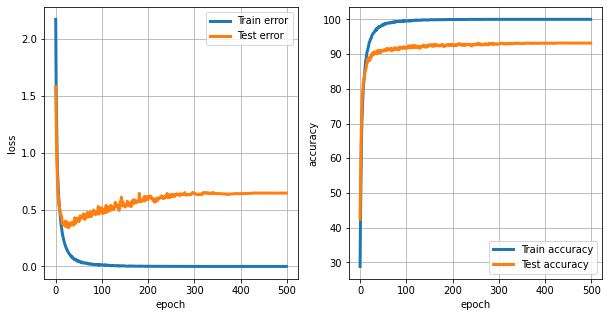

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [12]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)

Accuracy: 93.15664556962025
